In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as pdt
import re

from scipy.stats import chi2_contingency, chi2, chisquare

import pingouin as pg

import math
import pickle

In [2]:
#!pip install pingouin #für Anova bzw eta

# Data Setup
### 1. Daten laden

In [3]:
dfr = pd.read_pickle('data/dfr.pkl')

### 2. Zeiten formatieren und normalisieren

In [4]:
dfr["day_created"] = pd.to_datetime(dfr["day_created"]).dt.date
dfr["time_created"] = pd.to_datetime(dfr["time_created"]).dt.time
dfr["curr_time"] = pd.to_datetime(dfr["curr_time"])

dtstuff = dfr.apply(
    lambda row: datetime.combine(row['day_created'], row['time_created']),
    axis=1
)
dfr["time"] = dtstuff
dfr["time"] = dfr["time"] - timedelta(hours=10)

### 3. Eindeutige Posts filtern (Duplikate löschen)

In [5]:
dfr["post_id"] = dfr.agg('{0[author]}-{0[time]}'.format, axis=1) # dauert lange, ist aber wichtig
test = dfr.groupby("post_id")["ups"].agg('max').reset_index().rename({"ups":"max_ups"})
df = pd.merge(dfr, test, on="post_id")
dfr_wod = df.drop_duplicates(subset=["post_id"]).copy()

### 4. Daten bereinigen

In [6]:
def clean_data(title):
    cleaned_title = re.sub(r"\W", " ", title)
    cleaned_title = cleaned_title.lower()
    return cleaned_title

In [7]:
def get_specifier(title):
    cleaned_title = re.findall(r"\[((\w|\/| )*)\]", title)
    
    #\[([homemade]|[i ate]|[pro/chef])*\]
    #"\[.*\]"
    
    if cleaned_title:
        cleaned_title = cleaned_title[0][0].lower()
        if cleaned_title in ["homemade", "i ate", "pro/chef"]:
            return cleaned_title
    return "other"
    

In [8]:
dfr_wod.insert(0, column="cleaned_title", value=dfr_wod["title"].apply(clean_data))

# Abhängigkeit des Specifiers und der Upvote Anzahl

### 1. Filtern der Specifier

In [9]:
dfr_wod.insert(0, column="specifier_title", value=dfr_wod["title"].apply(get_specifier))
dfr_wod["specifier_title"].value_counts()

homemade    14250
i ate        2067
pro/chef      299
other           4
Name: specifier_title, dtype: int64

### 2. Daten weitergehend normalisieren
Daten werden hier in Gruppen zusammengefasst. Maximale Upvotes auf 100er, 1000er, 10.000er gerundet.

In [10]:
test = dfr_wod.groupby("specifier_title").agg("mean").reset_index()
test["std"] = dfr_wod.groupby("specifier_title").agg("std").reset_index()["ups_y"]

In [11]:
# Um die Daten ordinal zu machen
def roundup100(x):
    return int(math.ceil(x / 100.0)) * 100
def roundup1000(x):
    return int(math.ceil(x / 1000.0)) * 1000
def roundup10000(x):
    return int(math.ceil(x / 10000.0)) * 10000

In [12]:
dfr_wod["ups_rounded100"] = dfr_wod["ups_y"].apply(roundup100)
dfr_wod["ups_rounded1000"] = dfr_wod["ups_y"].apply(roundup1000)
dfr_wod["ups_rounded10000"] = dfr_wod["ups_y"].apply(roundup10000)

### 3. Chi-Quadrat Unabhängigkeitstest

In [13]:
X = pd.crosstab(dfr_wod["specifier_title"], dfr_wod["ups_rounded10000"])
y = list(dfr_wod["specifier_title"].value_counts().to_dict().keys())

In [14]:
chi2x = chi2_contingency(X)
chi2x
# Chi2 Unabhängigkeitstest (X2, p, Freiheitsgrade, erwartete Werte)

(93.58392189193287,
 3.2629893007372154e-12,
 18,
 array([[1.41385379e+04, 7.71660650e+01, 2.40072202e+01, 6.00180505e+00,
         1.71480144e+00, 1.71480144e+00, 8.57400722e-01],
        [2.05083213e+03, 1.11931408e+01, 3.48231047e+00, 8.70577617e-01,
         2.48736462e-01, 2.48736462e-01, 1.24368231e-01],
        [3.96871239e+00, 2.16606498e-02, 6.73886883e-03, 1.68471721e-03,
         4.81347774e-04, 4.81347774e-04, 2.40673887e-04],
        [2.96661252e+02, 1.61913357e+00, 5.03730445e-01, 1.25932611e-01,
         3.59807461e-02, 3.59807461e-02, 1.79903730e-02]]))

$X$² kann hier nicht genutzt werden, da nicht für alle gilt $h_i^e ≥ 5 $

### 4. Eta 

In [15]:
pg.anova(dv='ups_y', between='specifier_title', data=dfr_wod, detailed=True, effsize="n2")

,Source,SS,DF,MS,F,p-unc,n2
0,specifier_title,1.485612e+08,3,4.952039e+07,12.537606,3.483080e-08,0.002259
1,Within,6.562902e+10,16616,3.949749e+06,NaN,NaN,NaN


- .01: Small effect size
- .06: Medium effect size
- .14 or higher: Large effect size
> .0023 < .01
Daher kann hier kein Zusammenhang vermutet werden

### 5. Visualisierung der Ergebnisse

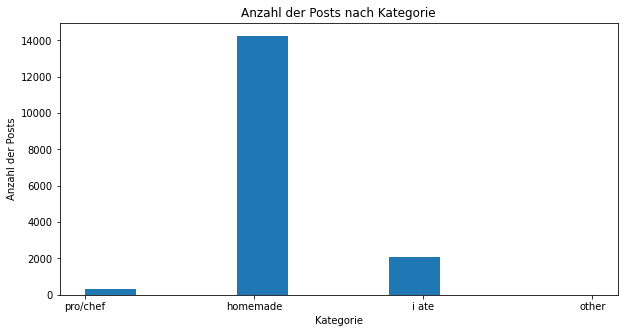

In [16]:
plt.figure(figsize=(10,5))
plt.hist(dfr_wod["specifier_title"])
plt.title("Anzahl der Posts nach Kategorie")
plt.ylabel("Anzahl der Posts")
plt.xlabel("Kategorie")

plt.show()

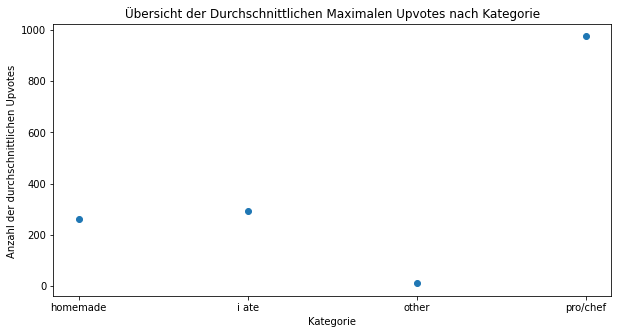

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(test["specifier_title"], test["ups_y"])
plt.title("Übersicht der Durchschnittlichen Maximalen Upvotes nach Kategorie")
plt.ylabel("Anzahl der durchschnittlichen Upvotes ")
plt.xlabel("Kategorie")
plt.show()

# Balkendiagramm

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


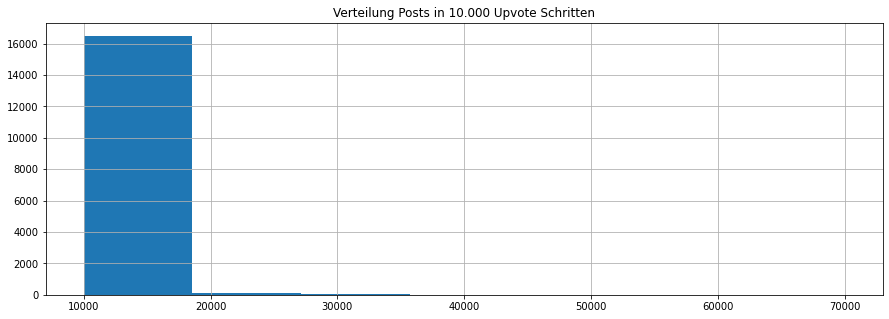

In [18]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
dfr_wod["ups_rounded10000"].hist(bins=7, ax=ax)
ax.set_title("Verteilung Posts in 10.000 Upvote Schritten")
fig.show()